Student Name: Daniel Ekale

Data Science Phase1 Project

Instructor : William Okomba, Nikita Njoroge, Samuel Karu, Antonny

### Overview:
In this analysis, we will explore the process of analyzing various movie datasets to identify trends and patterns in the types of films currently doing well at the box office. The ultimate goal is to provide actionable insights that can be used to guide decision-making at Microsoft's new movie studio.


###  Importing Libraries and Loading Data
To start, we need to import the necessary libraries and load the data into data frames. In this analysis, we will use pandas and matplotlib libraries.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

# Load data from csv files
movies = pd.read_csv('zippedData/bom.movie_gross.csv')
ratings = pd.read_csv('zippedData/rt.movie_info.tsv', sep='\t')
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv')
popular_movies = pd.read_csv('zippedData/tmdb.movies.csv', index_col = 0)

### Data Understanding
To begin my analysis, I first had to understand the data provided. The data came from several sources and included various file formats. The data sources were:
1. Box Office Mojo
2. IMDB
3. Rotten Tomatoes
4. TheMovieDB
5. The Numbers

The data included information on movie titles, release dates, genres, production companies, budgets, and box office revenue. Some of the data was provided in a SQLite database, while other data was in CSV or TSV file formats.

In [3]:
# Analyze the table movies
movies.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


### Data Cleaning
Now that we have our data loaded. We will check for null and duplicates. We will use proper ways to remove the null values or replace them with the most appropriate values. For example; For categorical values we are likely to replace the missing values with the mode. After this process we will have clean data to use for our analysis

In [4]:
# check if we have null values
movies.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [7]:
# This code checks for duplicated values in the dataset
movies.duplicated().sum()

0

In [5]:
#Replace the null values in studio gross column with mode since it has categorical values
mode_studio = movies.studio.mode()[0]
movies.studio.fillna(mode_studio, inplace = True)

#Replace the null values in domestic gross column with mean
mean_domestic_gross = movies.domestic_gross.mean()
movies.domestic_gross.fillna(mean_domestic_gross, inplace = True)

#drop column foreign gross since it has more missing values;
movies.drop('foreign_gross', axis = 1).head()

,title,studio,domestic_gross,year
0,Toy Story 3,BV,415000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,2010
3,Inception,WB,292600000.0,2010
4,Shrek Forever After,P/DW,238700000.0,2010


### Data analysis
Since we now have a clean data frame, we can start by checking which studios are actually doing well in the market already. This can be achieved by grouping the studios that have the highest domestic gross. We can then select and plot a bar graph of the first five.

In [6]:
# Order the studios from the one that has the highest domestic gross
movies.sort_values(by='domestic_gross', ascending=False, inplace=True)
domestic_gross_by_studio  = movies.groupby(['studio'])['domestic_gross'].sum().sort_values(ascending=False).head()
domestic_gross_by_studio

studio
BV      1.841903e+10
Uni.    1.290239e+10
WB      1.216805e+10
Fox     1.094950e+10
Sony    8.488429e+09
Name: domestic_gross, dtype: float64

### Visualization

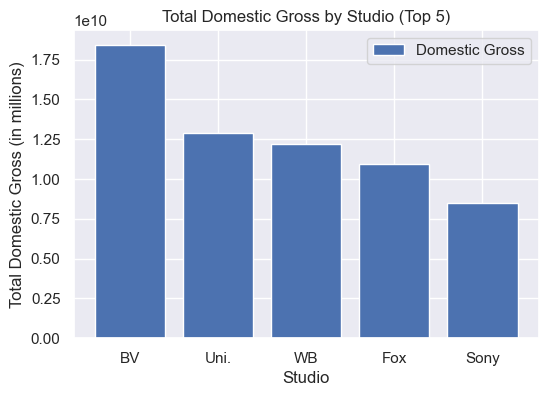

In [37]:
# Visualizing the first five studios with the highest domestic gross
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(domestic_gross_by_studio.index, domestic_gross_by_studio.values, label = "Domestic Gross")

# Set the title and axis labels
ax.set_title('Total Domestic Gross by Studio (Top 5)')
ax.set_xlabel('Studio')
ax.set_ylabel('Total Domestic Gross (in millions)')
ax.legend()
plt.show()

### Interpretation and recommendation
From the above analysis and visualziation we can clearly see that BV, Uni, WB Studio, Fox and Sony are the top five studios interms of domestic gross. If Micrososft is inteding to start a new studio I would recommend them to start a franchise type of business with the already existing successful studios. This will eneable them jump into the competitive market without forcing their way in. 

# Budgets Data
Let us explore and get some insights from the budgets dataset


In [16]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,month
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,12
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,5
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,6
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,5
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017,12


### Data cleaning
We will clean the provided dataset to check for null and duplicated values. We will then take the necessary actions to clean our data.

In [17]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
 6   year               5782 non-null   int64         
 7   month              5782 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 361.5+ KB


In [19]:
# Checking for null values
budgets.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
year                 0
month                0
dtype: int64

In [22]:
# Check for duplicates
budgets.duplicated().sum()

0

### Typecast the columns production budget, domestic gross, and worlwide gross
To be able to use these columns we must convert the values into floats

In [24]:
# Let us convert the columns production budget, domestics gross and worldwide gross into float
budgets['production_budget'] = budgets['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(float)
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)

C:\Users\Daniel Ekale\AppData\Local\Temp\ipykernel_4128\2001094820.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  budgets['production_budget'] = budgets['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)
C:\Users\Daniel Ekale\AppData\Local\Temp\ipykernel_4128\2001094820.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(float)
C:\Users\Daniel Ekale\AppData\Local\Temp\ipykernel_4128\2001094820.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions wil

### Identifying Best Months to Release a Movie
To identify the best months to release a movie, we need to extract the month from the release date and calculate the average box office revenue per month.

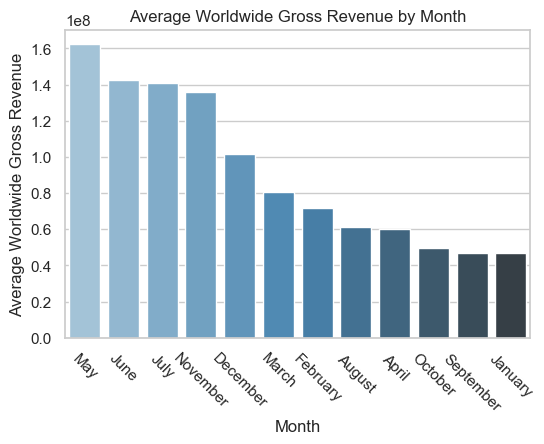

In [28]:
# Convert release_date column to datetime format
budgets['release_date'] = pd.to_datetime(budgets['release_date'])

# Extract month from release_date
budgets['month'] = budgets['release_date'].dt.month_name()

# Calculate average box office revenue per month
month_revenue = budgets.groupby('month')['worldwide_gross'].mean().sort_values(ascending=False)

# Create bar plot
sns.set_style('whitegrid')
ax = sns.barplot(x=month_revenue.index, y=month_revenue.values, palette='Blues_d')
ax.set_xlabel('Month')
ax.set_ylabel('Average Worldwide Gross Revenue')
ax.set_title('Average Worldwide Gross Revenue by Month')
plt.xticks(rotation=-45)
plt.show()


### Recommendation 2:
Based on the above analysis, we can recommend microsoft to release their movies in May, June, or July.

### Data from IM database

In [29]:
# creating a connection to im database
conn = sqlite3.connect('zippedData/im.db')

In [30]:
# checking all the tables in the database
table_name_query = """SELECT name 
                      AS 'Table Names' 
                      FROM sqlite_master 
                      WHERE type='table';"""

pd.read_sql(table_name_query, conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [58]:
# Here we merge two tables from the database
movie_basics_ratings = pd.read_sql("""
SELECT * FROM movie_basics
JOIN movie_ratings
USING(movie_id)

""",conn)

In [59]:
#The first rows of our data looks like this
movie_basics_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [48]:
# check for missing values
movie_basics_ratings.isna().sum()

movie_id              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7620
genres              804
averagerating         0
numvotes              0
dtype: int64

In [57]:
# Split the genres column into a list of genres
data['genres'] = data['genres']
data['genres']


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
73851   NaN
73852   NaN
73853   NaN
73854   NaN
73855   NaN
Name: genres, Length: 73856, dtype: float64

In [52]:
# Group the data by genre and calculate the mean of the average rating and the sum of the numvotes
grouped_data = data.groupby('genres').agg({'averagerating': 'mean', 'numvotes': 'sum'})

In [53]:
# Sort the data by the mean of the average rating
grouped_data = grouped_data.sort_values(by='averagerating', ascending=False)

# Filter the data by the number of votes
grouped_data = grouped_data[grouped_data['numvotes'] >= 10000]

# Print the result
print(grouped_data)

Empty DataFrame
Columns: [averagerating, numvotes]
Index: []


Empty DataFrame
Columns: [averagerating, numvotes]
Index: []
